In [1]:
from PIL import Image, ImageDraw
from openai import OpenAI
import base64
import re
 
import numpy as np
from datasets import load_dataset
from openai import OpenAI
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict, List
import base64
from io import BytesIO

c:\Users\Will\miniconda3\envs\cse291a\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helpers:

In [2]:
def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 data URL."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"


def build_uground_messages(description: str, image_url: str):
    """
    Build chat messages in OpenAI format for vision-language models.
    """
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": image_url},
                },
                {
                    "type": "text",
                    "text": (
                        "Find the coordinates of the element described below. "
                        "Return ONLY the coordinates in the format (x, y) with no additional text.\n"
                        f"Description: {description}\n"
                        "Coordinates:"
                    ),
                },
            ],
        }
    ]


def call_model_raw(
    image: Image.Image,
    query: str,
    client: OpenAI,
    model_name: str,
) -> Tuple[str, int, int]:
    """Send one screenshot + grounding query to the SGLang API."""
    orig_w, orig_h = image.size

    # Convert image to base64
    image_url = image_to_base64(image)

    # Build messages in OpenAI format
    messages = build_uground_messages(query, image_url)

    try:
        # Call SGLang API (OpenAI-compatible)
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            max_tokens=128,
            temperature=0.0,
        )

        reply = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call error: {e}")
        reply = ""

    return reply, orig_w, orig_h


In [3]:
def parse_xy_from_string(text: str) -> Tuple[int, int]:
    """
    Extract (x, y) coordinates from a string.
    Handles various formats:
    - (x, y) - two coordinates
    - (x1, y1, x2, y2) - four coordinates (bbox), computes center
    - Multiple coordinate pairs - takes the first valid one
    """
    if not text or not text.strip():
        raise ValueError("Empty text provided")

    # Clean the text - remove extra whitespace and newlines
    text = text.strip()

    # Try to find coordinate patterns: (num, num) or (num, num, num, num)
    pattern_two = re.findall(r"\(\s*(\d+)\s*,\s*(\d+)\s*\)", text)
    pattern_four = re.findall(r"\(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\)", text)

    # First try to find a simple (x, y) pair in [0, 1000) range
    if pattern_two:
        for match in pattern_two:
            x, y = int(match[0]), int(match[1])
            if 0 <= x < 1000 and 0 <= y < 1000:
                return x, y

    # If we found a bbox format (x1, y1, x2, y2), compute center
    if pattern_four:
        for match in pattern_four:
            x1, y1, x2, y2 = int(match[0]), int(match[1]), int(match[2]), int(match[3])
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            if 0 <= center_x < 1000 and 0 <= center_y < 1000:
                return center_x, center_y
            if 0 <= x1 < 1000 and 0 <= y1 < 1000:
                return x1, y1

    # Fallback: try to extract just the first two numbers
    numbers = re.findall(r"\d+", text)
    if len(numbers) >= 2:
        x, y = int(numbers[0]), int(numbers[1])
        x = max(0, min(999, x))
        y = max(0, min(999, y))
        return x, y

    raise ValueError(f"Could not parse valid coordinates from: {text[:200]!r}")


def scale_to_pixels(x_1000: int, y_1000: int, width: int, height: int) -> Tuple[int, int]:
    """
    Map model coordinates in [0,1000) to pixel coordinates of the original image.
    """
    x_px = int(x_1000 / 1000 * width)
    y_px = int(y_1000 / 1000 * height)
    x_px = max(0, min(width - 1, x_px))
    y_px = max(0, min(height - 1, y_px))
    return x_px, y_px


def predict_coordinates(
    image: Image.Image,
    query: str,
    model_key: str,
) -> Tuple[int, int, str]:
    """
    Predict coordinates using the specified model via vLLM OpenAI endpoint.
    Returns: (x_px, y_px, raw_response)
    """
    cfg = MODEL_CONFIGS[model_key]
    client = clients[model_key]
    model_name = cfg["model_id"]

    reply, orig_w, orig_h = call_model_raw(image, query, client, model_name)

    # If reply is empty, return center as fallback
    if not reply or reply.strip() == "":
        return orig_w // 2, orig_h // 2, reply

    try:
        x_1000, y_1000 = parse_xy_from_string(reply)
        x_px, y_px = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)
        return x_px, y_px, reply
    except ValueError as e:
        # If parsing fails, return center of image as fallback
        # Only print warning if reply is not empty (to avoid spam)
        if reply.strip():
            print(
                f"Warning: Failed to parse coordinates from {model_key}: "
                f"{e}, reply: {reply[:50]}"
            )
        return orig_w // 2, orig_h // 2, reply


def euclidean_distance(x1: int, y1: int, x2: int, y2: int) -> float:
    """Calculate Euclidean distance between two points."""
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def bbox_to_center(bbox: List[int]) -> Tuple[int, int]:
    """
    Convert bounding box [x1, y1, x2, y2] to center coordinates (x, y).
    """
    if len(bbox) != 4:
        raise ValueError(f"Bbox must have 4 elements, got {len(bbox)}")
    else:
        x1, y1, x2, y2 = bbox
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        return center_x, center_y


### 1. Dataset (Click-100K):

In [4]:
from datasets import load_dataset, Dataset
from itertools import islice

print("Loading Click-100k dataset (streaming)...")
# 1. Streaming mode: doesn't pre-download all shards
stream = load_dataset(
    "mlfoundations/Click-100k",
    split="train",
    streaming=True,
)

# 2. Take only the first 100 samples from the stream
first_100 = list(islice(stream, 100))

# 3. Turn them into a regular Dataset, just like before
eval_dataset = Dataset.from_list(first_100)

print(f"Evaluating on {len(eval_dataset)} samples")
print(f"\nDataset features: {eval_dataset.features}")
print(f"\nSample keys: {eval_dataset[0].keys()}")


Loading Click-100k dataset (streaming)...
Evaluating on 100 samples

Dataset features: {'image_path': Value('string'), 'images': List(Image(mode=None, decode=True)), 'easyr1_prompt': Value('string'), 'bbox': List(Value('int64')), 'image_width': Value('int64'), 'image_height': Value('int64'), 'normalized_bbox': List(Value('float64'))}

Sample keys: dict_keys(['image_path', 'images', 'easyr1_prompt', 'bbox', 'image_width', 'image_height', 'normalized_bbox'])


### 2.1 Evaluations (Accuracy):

In [5]:
import json
from typing import Dict, List
from tqdm import tqdm
from PIL import Image
from openai import OpenAI

# Assume these already exist from earlier:
# - eval_dataset
# - call_model_raw
# - bbox_to_center
# - euclidean_distance
# - parse_xy_from_string
# - scale_to_pixels

lmstudio_client = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio",
)

def evaluate_model_in_lmstudio(
    model_key: str,   # short name, e.g. "ui-tars-7b-dpo-q4"
    model_id: str,    # the name LM Studio expects in `model=...`
    client: OpenAI,
) -> List[Dict]:
    """
    Run evaluation for a single model loaded in LM Studio.
    Returns a list of per-sample result dicts.
    """
    results_for_model: List[Dict] = []

    print(f"\n=== Evaluating model: {model_key} ({model_id}) ===")

    for idx in tqdm(range(len(eval_dataset)), desc=f"Processing samples ({model_key})"):
        sample = eval_dataset[idx]

        # 1) Image
        images_list = sample.get("images")
        if images_list is None or len(images_list) == 0:
            print(f"Skipping sample {idx}: no images found")
            continue

        image = images_list[0]
        if not isinstance(image, Image.Image):
            if hasattr(image, "convert"):
                image = image.convert("RGB")
            else:
                print(f"Skipping sample {idx}: cannot process image format")
                continue

        orig_w, orig_h = image.size

        # 2) Query
        query = sample.get("easyr1_prompt")
        if query is None:
            print(f"Skipping sample {idx}: missing query")
            continue

        # 3) GT bbox → center
        bbox = sample.get("bbox")
        if bbox is None or len(bbox) != 4:
            print(f"Skipping sample {idx}: invalid bbox {bbox}")
            continue

        try:
            gt_x, gt_y = bbox_to_center(bbox)
        except Exception as e:
            print(f"Skipping sample {idx}: error converting bbox: {e}")
            continue

        # 4) Call LM Studio via call_model_raw
        try:
            reply, _, _ = call_model_raw(
                image=image,
                query=query,
                client=client,
                model_name=model_id,
            )

            # Empty reply → fallback to center
            if not reply or reply.strip() == "":
                pred_x, pred_y = orig_w // 2, orig_h // 2
                distance = euclidean_distance(pred_x, pred_y, gt_x, gt_y)

                results_for_model.append({
                    "sample_idx": idx,
                    "query": query,
                    "bbox": bbox,
                    "gt_x": gt_x,
                    "gt_y": gt_y,
                    "pred_x": pred_x,
                    "pred_y": pred_y,
                    "distance": distance,
                    "raw_response": reply,
                    "empty_reply": True,
                })
                continue

            # Parse coords and rescale
            x_1000, y_1000 = parse_xy_from_string(reply)
            pred_x, pred_y = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)
            distance = euclidean_distance(pred_x, pred_y, gt_x, gt_y)

            results_for_model.append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": pred_x,
                "pred_y": pred_y,
                "distance": distance,
                "raw_response": reply,
            })

        except Exception as e:
            print(f"Error processing sample {idx} with {model_key}: {e}")
            results_for_model.append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": None,
                "pred_y": None,
                "distance": float("inf"),
                "raw_response": str(e),
                "error": True,
            })

    print(f"=== Done: {model_key} ({len(results_for_model)} samples recorded) ===")
    return results_for_model


def save_results_to_json(model_key: str, results_for_model: List[Dict], out_dir: str = "./results"):
    import os
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"results_{model_key}.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results_for_model, f, ensure_ascii=False, indent=2)
    print(f"Saved {model_key} results to {out_path}")


In [6]:
model_key = "ui-tars-7b-dpo@f16"
model_id = "ui-tars-7b-dpo@f16"

results_for_model = evaluate_model_in_lmstudio(
    model_key=model_key,
    model_id=model_id,
    client=lmstudio_client,
)

save_results_to_json(model_key, results_for_model, out_dir="./results")


=== Evaluating model: ui-tars-7b-dpo@f16 (ui-tars-7b-dpo@f16) ===


Processing samples (ui-tars-7b-dpo@f16): 100%|██████████| 100/100 [11:34:57<00:00, 416.98s/it]    

=== Done: ui-tars-7b-dpo@f16 (100 samples recorded) ===
Saved ui-tars-7b-dpo@f16 results to ./results\results_ui-tars-7b-dpo@f16.json


### 2.2 Evaluations (Time):

In [15]:
import time
from typing import Dict, List
from tqdm import tqdm
from PIL import Image
from openai import OpenAI

# lmstudio_client defined as before
lmstudio_client = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio",
)


def evaluate_model_in_lmstudio(
    model_key: str,   # short name, e.g. "ui-tars-7b-dpo-q4"
    model_id: str,    # LM Studio model name
    client: OpenAI,
    max_samples: int = 20,
) -> List[Dict]:
    """
    Run evaluation for a single model loaded in LM Studio.
    Measures per-sample latency and distance.
    Returns a list of per-sample result dicts.
    """
    results_for_model: List[Dict] = []

    n = min(len(eval_dataset), max_samples)
    print(f"\n=== Evaluating model: {model_key} ({model_id}) on {n} samples ===")

    for idx in tqdm(range(n), desc=f"Processing samples ({model_key})"):
        sample = eval_dataset[idx]

        # 1) Image
        images_list = sample.get("images")
        if images_list is None or len(images_list) == 0:
            print(f"Skipping sample {idx}: no images found")
            continue

        image = images_list[0]
        if not isinstance(image, Image.Image):
            if hasattr(image, "convert"):
                image = image.convert("RGB")
            else:
                print(f"Skipping sample {idx}: cannot process image format")
                continue

        orig_w, orig_h = image.size

        # 2) Query
        query = sample.get("easyr1_prompt")
        if query is None:
            print(f"Skipping sample {idx}: missing query")
            continue

        # 3) GT bbox → center
        bbox = sample.get("bbox")
        if bbox is None or len(bbox) != 4:
            print(f"Skipping sample {idx}: invalid bbox {bbox}")
            continue

        try:
            gt_x, gt_y = bbox_to_center(bbox)
        except Exception as e:
            print(f"Skipping sample {idx}: error converting bbox: {e}")
            continue

        # 4) Time the model call
        try:
            start = time.perf_counter()
            reply, _, _ = call_model_raw(
                image=image,
                query=query,
                client=client,
                model_name=model_id,
            )
            end = time.perf_counter()
            latency_sec = end - start

            # Empty reply → fallback to center
            if not reply or reply.strip() == "":
                pred_x, pred_y = orig_w // 2, orig_h // 2
                distance = euclidean_distance(pred_x, pred_y, gt_x, gt_y)

                results_for_model.append({
                    "sample_idx": idx,
                    "query": query,
                    "bbox": bbox,
                    "gt_x": gt_x,
                    "gt_y": gt_y,
                    "pred_x": pred_x,
                    "pred_y": pred_y,
                    "distance": distance,
                    "raw_response": reply,
                    "empty_reply": True,
                    "latency_sec": latency_sec,
                })
                continue

            # Parse coords and rescale
            x_1000, y_1000 = parse_xy_from_string(reply)
            pred_x, pred_y = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)
            distance = euclidean_distance(pred_x, pred_y, gt_x, gt_y)

            results_for_model.append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": pred_x,
                "pred_y": pred_y,
                "distance": distance,
                "raw_response": reply,
                "latency_sec": latency_sec,
            })

        except Exception as e:
            print(f"Error processing sample {idx} with {model_key}: {e}")
            results_for_model.append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": None,
                "pred_y": None,
                "distance": float("inf"),
                "raw_response": str(e),
                "error": True,
                "latency_sec": None,
            })

    print(f"=== Done: {model_key} ({len(results_for_model)} samples recorded) ===")
    return results_for_model


In [20]:
model_key = "ui-tars-7b-dpo@q2_k-t"
model_id = "ui-tars-7b-dpo@q2_k"

results_for_model = evaluate_model_in_lmstudio(
    model_key=model_key,
    model_id=model_id,
    client=lmstudio_client,
)

save_results_to_json(model_key, results_for_model, out_dir="./results-t")


=== Evaluating model: ui-tars-7b-dpo@q2_k-t (ui-tars-7b-dpo@q2_k) on 20 samples ===


Processing samples (ui-tars-7b-dpo@q2_k-t): 100%|██████████| 20/20 [13:39<00:00, 40.95s/it]

=== Done: ui-tars-7b-dpo@q2_k-t (20 samples recorded) ===
Saved ui-tars-7b-dpo@q2_k-t results to ./results-t\results_ui-tars-7b-dpo@q2_k-t.json


### 3.1 Visualization (Accuracy):

In [7]:
import json
import os
from typing import Dict, List

RESULTS_DIR = "./results"

# List of models you actually evaluated:
MODEL_KEYS = [
    "ui-tars-7b-dpo@q2_k",
    "ui-tars-7b-dpo@q4_k_s",
    "ui-tars-7b-dpo@q6_k",
    "ui-tars-7b-dpo@q8_0",
    "ui-tars-7b-dpo@f16"
]

# Aggregate results into the format your metric/plot code expects:
all_results: Dict[str, List[Dict]] = {}

for model_key in MODEL_KEYS:
    path = os.path.join(RESULTS_DIR, f"results_{model_key}.json")
    if not os.path.exists(path):
        print(f"Warning: missing results file for {model_key}: {path}")
        continue

    with open(path, "r", encoding="utf-8") as f:
        all_results[model_key] = json.load(f)

print("Loaded models:", list(all_results.keys()))


Loaded models: ['ui-tars-7b-dpo@q2_k', 'ui-tars-7b-dpo@q4_k_s', 'ui-tars-7b-dpo@q6_k', 'ui-tars-7b-dpo@q8_0', 'ui-tars-7b-dpo@f16']


In [9]:
from typing import List, Dict
import numpy as np

def calculate_metrics(results_for_model: List[Dict]) -> Dict:
    """Calculate evaluation metrics for a single model."""
    # Filter out failed predictions (distance = inf or missing)
    distances = [
        r["distance"]
        for r in results_for_model
        if "distance" in r and r["distance"] != float("inf")
    ]

    if not distances:
        return {
            "mean_distance": float("inf"),
            "median_distance": float("inf"),
            "std_distance": float("inf"),
            "accuracy_5px": 0.0,
            "accuracy_10px": 0.0,
            "accuracy_20px": 0.0,
            "accuracy_50px": 0.0,
            "total_samples": len(results_for_model),
            "successful_samples": 0,
        }

    distances = np.array(distances)

    # Calculate accuracy at different thresholds (in pixels)
    thresholds = [5, 10, 20, 50]
    accuracies = {}
    for threshold in thresholds:
        accuracies[f"accuracy_{threshold}px"] = float(
            np.mean(distances <= threshold) * 100.0
        )

    return {
        "mean_distance": float(np.mean(distances)),
        "median_distance": float(np.median(distances)),
        "std_distance": float(np.std(distances)),
        **accuracies,
        "total_samples": len(results_for_model),
        "successful_samples": len(distances),
    }

metrics = {}

for model_key, model_results in all_results.items():
    metrics[model_key] = calculate_metrics(model_results)

    print(f"\n{model_key.upper()} Metrics:")
    print(f" Mean Distance Error: {metrics[model_key]['mean_distance']:.2f} px")
    print(f" Median Distance Error: {metrics[model_key]['median_distance']:.2f} px")
    print(f" Std Distance Error: {metrics[model_key]['std_distance']:.2f} px")
    print(f" Accuracy @ 5px:  {metrics[model_key]['accuracy_5px']:.2f}%")
    print(f" Accuracy @ 10px: {metrics[model_key]['accuracy_10px']:.2f}%")
    print(f" Accuracy @ 20px: {metrics[model_key]['accuracy_20px']:.2f}%")
    print(f" Accuracy @ 50px: {metrics[model_key]['accuracy_50px']:.2f}%")
    print(
        f" Successful Predictions: "
        f"{metrics[model_key]['successful_samples']}/"
        f"{metrics[model_key]['total_samples']}"
    )



UI-TARS-7B-DPO@Q2_K Metrics:
 Mean Distance Error: 148.44 px
 Median Distance Error: 39.71 px
 Std Distance Error: 262.08 px
 Accuracy @ 5px:  10.00%
 Accuracy @ 10px: 16.00%
 Accuracy @ 20px: 34.00%
 Accuracy @ 50px: 57.00%
 Successful Predictions: 100/100

UI-TARS-7B-DPO@Q4_K_S Metrics:
 Mean Distance Error: 164.20 px
 Median Distance Error: 45.96 px
 Std Distance Error: 253.89 px
 Accuracy @ 5px:  10.00%
 Accuracy @ 10px: 17.00%
 Accuracy @ 20px: 35.00%
 Accuracy @ 50px: 53.00%
 Successful Predictions: 100/100

UI-TARS-7B-DPO@Q6_K Metrics:
 Mean Distance Error: 160.87 px
 Median Distance Error: 47.51 px
 Std Distance Error: 281.65 px
 Accuracy @ 5px:  6.00%
 Accuracy @ 10px: 16.00%
 Accuracy @ 20px: 30.00%
 Accuracy @ 50px: 55.00%
 Successful Predictions: 100/100

UI-TARS-7B-DPO@Q8_0 Metrics:
 Mean Distance Error: 161.82 px
 Median Distance Error: 39.24 px
 Std Distance Error: 281.44 px
 Accuracy @ 5px:  8.00%
 Accuracy @ 10px: 17.00%
 Accuracy @ 20px: 32.00%
 Accuracy @ 50px: 58.0

In [10]:
import pandas as pd

comparison_data = []
for model_key, m in metrics.items():
    comparison_data.append({
        "Model": model_key,
        "Mean Distance (px)": f"{m['mean_distance']:.2f}",
        "Median Distance (px)": f"{m['median_distance']:.2f}",
        "Std Distance (px)": f"{m['std_distance']:.2f}",
        "Accuracy @ 5px (%)": f"{m['accuracy_5px']:.2f}",
        "Accuracy @ 10px (%)": f"{m['accuracy_10px']:.2f}",
        "Accuracy @ 20px (%)": f"{m['accuracy_20px']:.2f}",
        "Accuracy @ 50px (%)": f"{m['accuracy_50px']:.2f}",
        "Success Rate": f"{m['successful_samples']}/{m['total_samples']}",
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(df_comparison.to_string(index=False))
print("=" * 80)



MODEL COMPARISON
                Model Mean Distance (px) Median Distance (px) Std Distance (px) Accuracy @ 5px (%) Accuracy @ 10px (%) Accuracy @ 20px (%) Accuracy @ 50px (%) Success Rate
  ui-tars-7b-dpo@q2_k             148.44                39.71            262.08              10.00               16.00               34.00               57.00      100/100
ui-tars-7b-dpo@q4_k_s             164.20                45.96            253.89              10.00               17.00               35.00               53.00      100/100
  ui-tars-7b-dpo@q6_k             160.87                47.51            281.65               6.00               16.00               30.00               55.00      100/100
  ui-tars-7b-dpo@q8_0             161.82                39.24            281.44               8.00               17.00               32.00               58.00      100/100
   ui-tars-7b-dpo@f16             159.04                41.11            280.21               8.00               16.00    

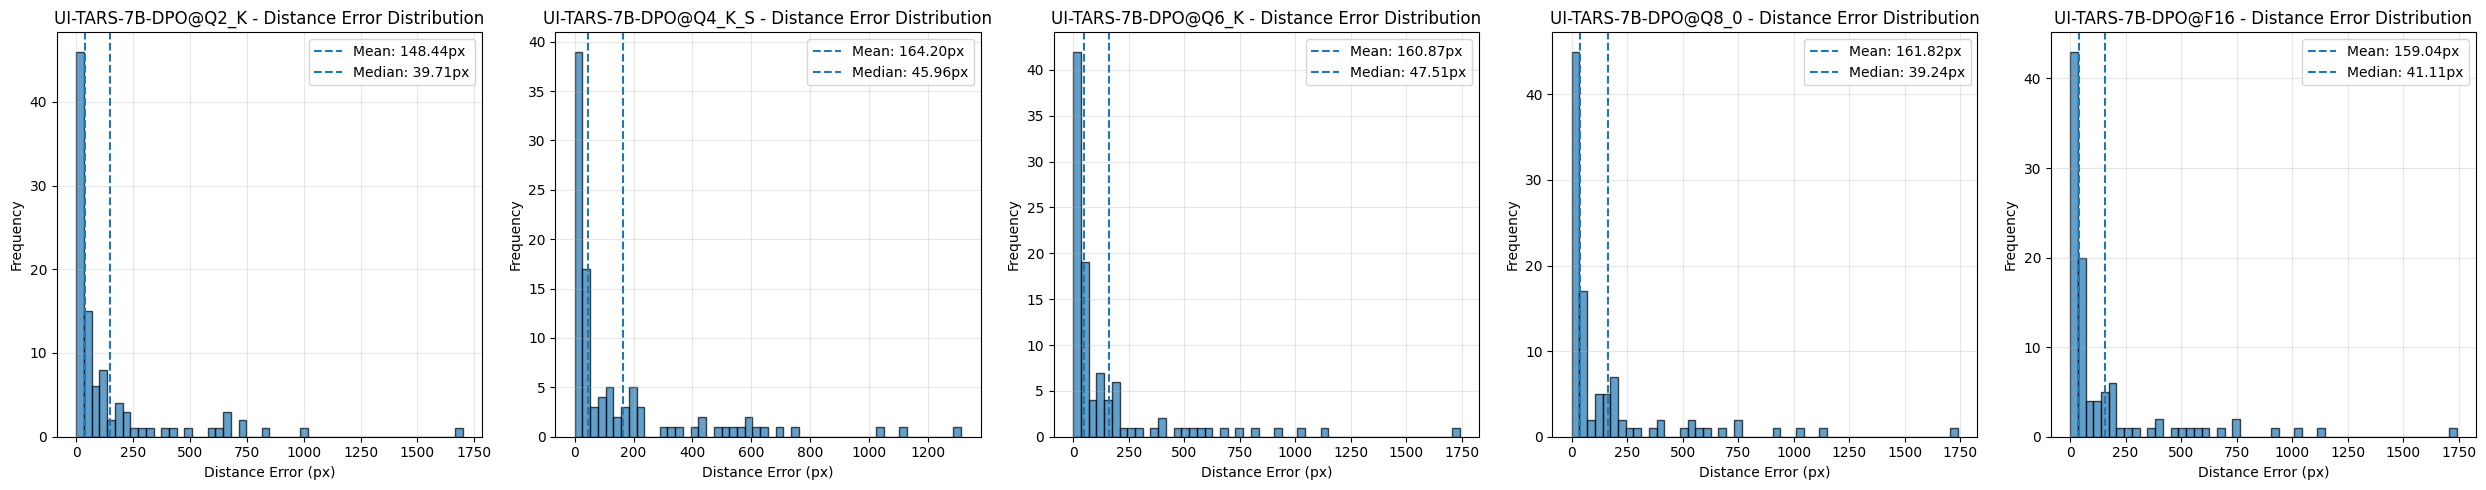

In [11]:
import matplotlib.pyplot as plt
import numpy as np

model_keys = list(all_results.keys())
n_models = len(model_keys)

fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
if n_models == 1:
    axes = [axes]

for idx, model_key in enumerate(model_keys):
    distances = [
        r["distance"]
        for r in all_results[model_key]
        if r.get("distance") is not None and r.get("distance") != float("inf")
    ]

    ax = axes[idx]

    if distances:
        distances = np.array(distances)
        ax.hist(distances, bins=50, alpha=0.7, edgecolor="black")
        ax.axvline(np.mean(distances), linestyle="--",
                   label=f"Mean: {np.mean(distances):.2f}px")
        ax.axvline(np.median(distances), linestyle="--",
                   label=f"Median: {np.median(distances):.2f}px")
        ax.set_xlabel("Distance Error (px)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{model_key.upper()} - Distance Error Distribution")
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(
            0.5, 0.5, "No valid predictions",
            ha="center", va="center", transform=ax.transAxes
        )
        ax.set_title(f"{model_key.upper()} - No Data")

plt.tight_layout()
plt.show()


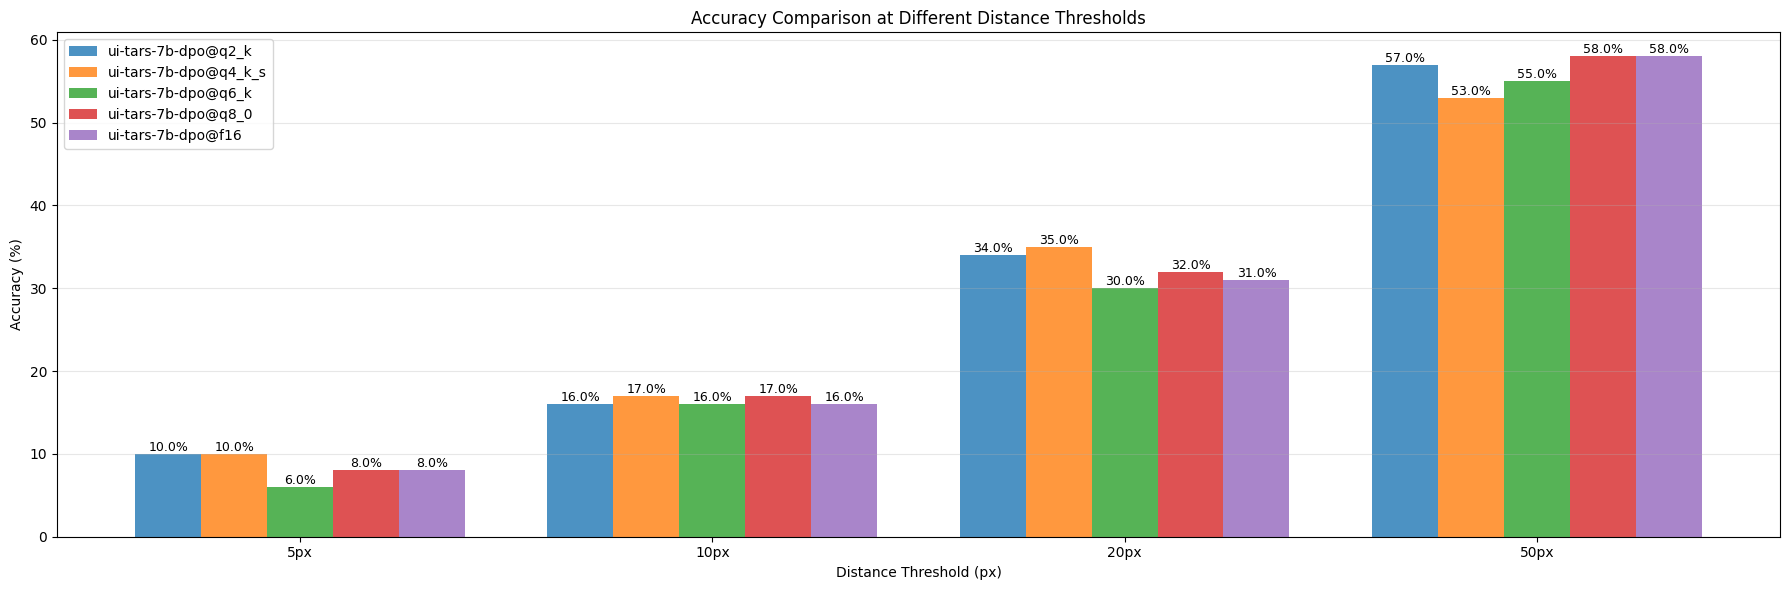

In [12]:
thresholds = [5, 10, 20, 50]
x = np.arange(len(thresholds))
model_keys = list(metrics.keys())

fig, ax = plt.subplots(figsize=(8 + 2 * len(model_keys), 6))

width = 0.8 / max(len(model_keys), 1)
bars_all = []

for idx, model_key in enumerate(model_keys):
    offsets = (idx - (len(model_keys) - 1) / 2) * width
    accs = [metrics[model_key][f"accuracy_{t}px"] for t in thresholds]
    bars = ax.bar(x + offsets, accs, width, label=model_key, alpha=0.8)
    bars_all.append(bars)

ax.set_xlabel("Distance Threshold (px)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy Comparison at Different Distance Thresholds")
ax.set_xticks(x)
ax.set_xticklabels([f"{t}px" for t in thresholds])
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

for bars in bars_all:
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            h,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()


### 3.2 Visulizations (Time):

In [21]:
import json
import os
from typing import Dict, List

RESULTS_DIR = "./results-t"

# List of models you actually evaluated:
MODEL_KEYS = [
    "ui-tars-7b-dpo@q2_k-t",
    "ui-tars-7b-dpo@q4_k_s-t",
    "ui-tars-7b-dpo@q6_k-t",
    "ui-tars-7b-dpo@q8_0-t",
    "ui-tars-7b-dpo@f16-t"
]

# Aggregate results into the format your metric/plot code expects:
all_results: Dict[str, List[Dict]] = {}

for model_key in MODEL_KEYS:
    path = os.path.join(RESULTS_DIR, f"results_{model_key}.json")
    if not os.path.exists(path):
        print(f"Warning: missing results file for {model_key}: {path}")
        continue

    with open(path, "r", encoding="utf-8") as f:
        all_results[model_key] = json.load(f)

print("Loaded models:", list(all_results.keys()))


Loaded models: ['ui-tars-7b-dpo@q2_k-t', 'ui-tars-7b-dpo@q4_k_s-t', 'ui-tars-7b-dpo@q6_k-t', 'ui-tars-7b-dpo@q8_0-t', 'ui-tars-7b-dpo@f16-t']


In [22]:
def calculate_runtime_metrics(results_for_model: List[Dict]) -> Dict:
    """Compute runtime metrics (latency) for a single model."""
    latencies = [
        r["latency_sec"]
        for r in results_for_model
        if r.get("latency_sec") is not None
    ]

    if not latencies:
        return {
            "mean_latency_ms": float("inf"),
            "median_latency_ms": float("inf"),
            "p95_latency_ms": float("inf"),
            "min_latency_ms": float("inf"),
            "max_latency_ms": float("inf"),
            "num_timed_samples": 0,
        }

    latencies = np.array(latencies) * 1000.0  # convert to ms

    return {
        "mean_latency_ms": float(np.mean(latencies)),
        "median_latency_ms": float(np.median(latencies)),
        "p95_latency_ms": float(np.percentile(latencies, 95)),
        "min_latency_ms": float(np.min(latencies)),
        "max_latency_ms": float(np.max(latencies)),
        "num_timed_samples": len(latencies),
    }


runtime_metrics = {}

for model_key, model_results in all_results.items():
    runtime_metrics[model_key] = calculate_runtime_metrics(model_results)

    m = runtime_metrics[model_key]
    print(f"\n{model_key.upper()} Runtime Metrics:")
    print(f" Mean latency:   {m['mean_latency_ms']:.1f} ms")
    print(f" Median latency: {m['median_latency_ms']:.1f} ms")
    print(f" P95 latency:    {m['p95_latency_ms']:.1f} ms")
    print(f" Min latency:    {m['min_latency_ms']:.1f} ms")
    print(f" Max latency:    {m['max_latency_ms']:.1f} ms")
    print(f" Timed samples:  {m['num_timed_samples']}")



UI-TARS-7B-DPO@Q2_K-T Runtime Metrics:
 Mean latency:   40947.7 ms
 Median latency: 33679.4 ms
 P95 latency:    82022.7 ms
 Min latency:    6483.7 ms
 Max latency:    87765.1 ms
 Timed samples:  20

UI-TARS-7B-DPO@Q4_K_S-T Runtime Metrics:
 Mean latency:   25107.8 ms
 Median latency: 20294.3 ms
 P95 latency:    49580.3 ms
 Min latency:    4196.2 ms
 Max latency:    55576.5 ms
 Timed samples:  20

UI-TARS-7B-DPO@Q6_K-T Runtime Metrics:
 Mean latency:   47583.5 ms
 Median latency: 39662.4 ms
 P95 latency:    89804.8 ms
 Min latency:    7860.3 ms
 Max latency:    101038.9 ms
 Timed samples:  20

UI-TARS-7B-DPO@Q8_0-T Runtime Metrics:
 Mean latency:   40168.2 ms
 Median latency: 31594.0 ms
 P95 latency:    78813.4 ms
 Min latency:    7023.4 ms
 Max latency:    84322.4 ms
 Timed samples:  20

UI-TARS-7B-DPO@F16-T Runtime Metrics:
 Mean latency:   55476.7 ms
 Median latency: 44834.1 ms
 P95 latency:    102460.3 ms
 Min latency:    10576.4 ms
 Max latency:    110342.5 ms
 Timed samples:  20


In [23]:
import pandas as pd

runtime_rows = []
for model_key, m in runtime_metrics.items():
    runtime_rows.append({
        "Model": model_key,
        "Mean Latency (ms)": f"{m['mean_latency_ms']:.1f}",
        "Median Latency (ms)": f"{m['median_latency_ms']:.1f}",
        "P95 Latency (ms)": f"{m['p95_latency_ms']:.1f}",
        "Min Latency (ms)": f"{m['min_latency_ms']:.1f}",
        "Max Latency (ms)": f"{m['max_latency_ms']:.1f}",
        "# Timed Samples": m["num_timed_samples"],
    })

df_runtime = pd.DataFrame(runtime_rows)

print("\n" + "=" * 80)
print("MODEL RUNTIME COMPARISON (20-SAMPLE BENCHMARK)")
print("=" * 80)
print(df_runtime.to_string(index=False))
print("=" * 80)



MODEL RUNTIME COMPARISON (20-SAMPLE BENCHMARK)
                  Model Mean Latency (ms) Median Latency (ms) P95 Latency (ms) Min Latency (ms) Max Latency (ms)  # Timed Samples
  ui-tars-7b-dpo@q2_k-t           40947.7             33679.4          82022.7           6483.7          87765.1               20
ui-tars-7b-dpo@q4_k_s-t           25107.8             20294.3          49580.3           4196.2          55576.5               20
  ui-tars-7b-dpo@q6_k-t           47583.5             39662.4          89804.8           7860.3         101038.9               20
  ui-tars-7b-dpo@q8_0-t           40168.2             31594.0          78813.4           7023.4          84322.4               20
   ui-tars-7b-dpo@f16-t           55476.7             44834.1         102460.3          10576.4         110342.5               20


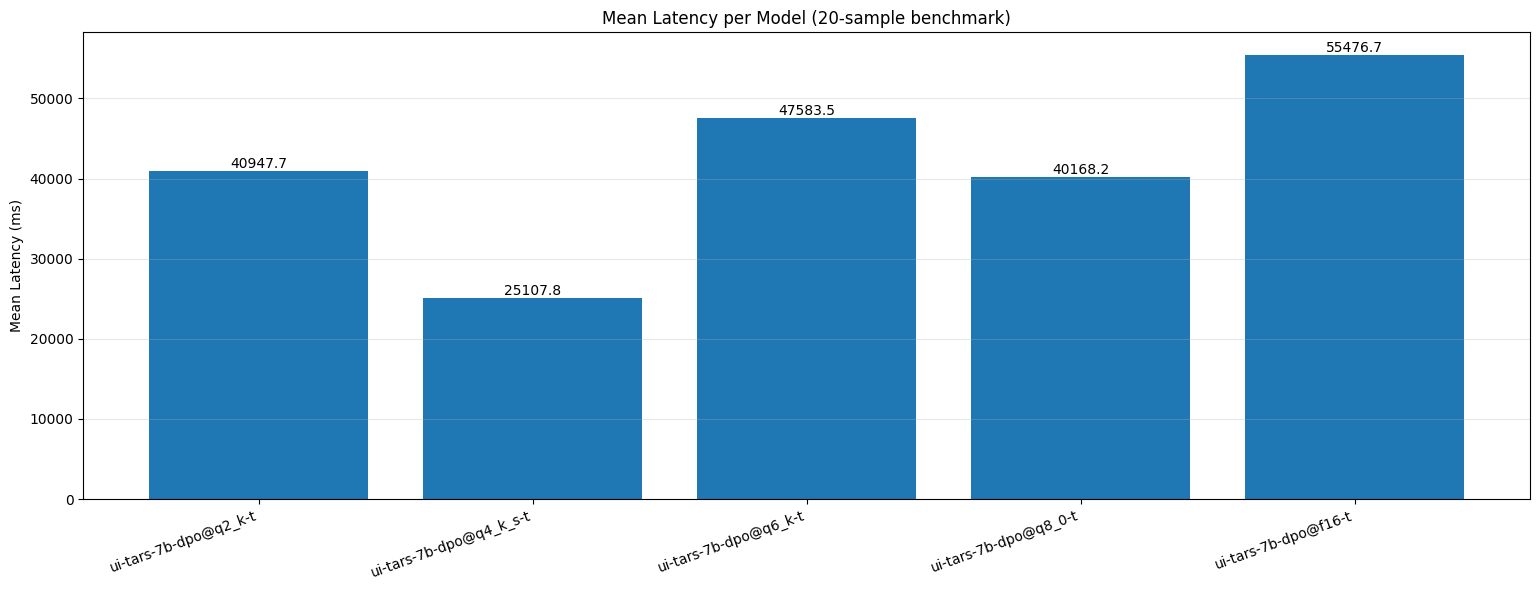

In [24]:
import matplotlib.pyplot as plt
import numpy as np

model_keys = list(runtime_metrics.keys())
mean_latencies = [runtime_metrics[k]["mean_latency_ms"] for k in model_keys]

x = np.arange(len(model_keys))

fig, ax = plt.subplots(figsize=(8 + 1.5 * len(model_keys), 6))
bars = ax.bar(x, mean_latencies)

ax.set_ylabel("Mean Latency (ms)")
ax.set_title("Mean Latency per Model (20-sample benchmark)")
ax.set_xticks(x)
ax.set_xticklabels(model_keys, rotation=20, ha="right")
ax.grid(True, axis="y", alpha=0.3)

# labels on bars
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        h,
        f"{h:.1f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()
